C:\Users\anush\AppData\Local\Temp\ipykernel_20252\2825770792.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Acceleration(m/s^2)'] = df['Speed(m/s)'].diff() / df['Time_Diff'].replace(0, pd.NA).fillna(1)
C:\Users\anush\AppData\Local\Temp\ipykernel_20252\2825770792.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Jerk(m/s^3)'] = df['Acceleration(m/s^2)'].diff() / df['Time_Diff'].replace(0, pd.NA).fillna(1)


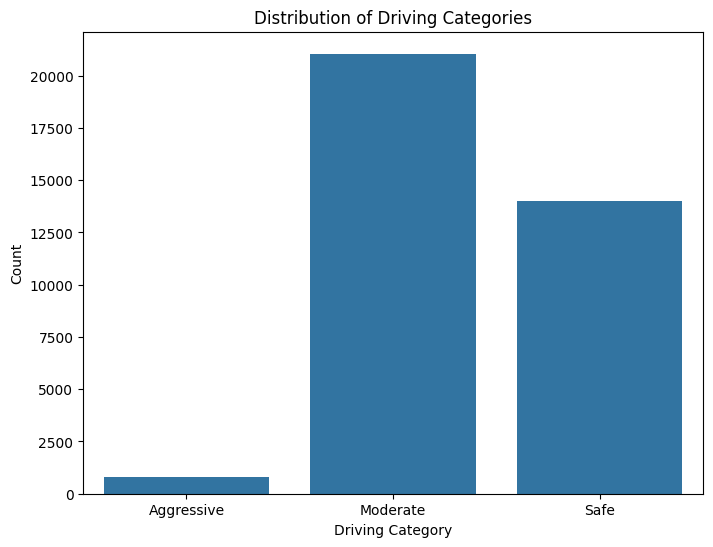

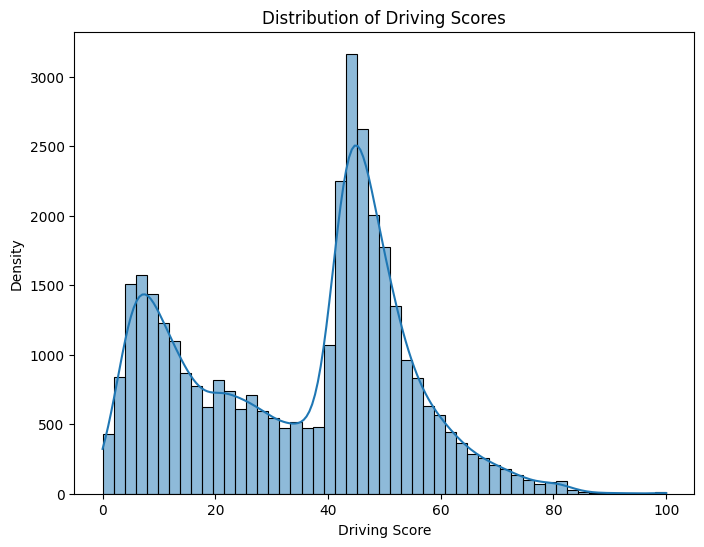

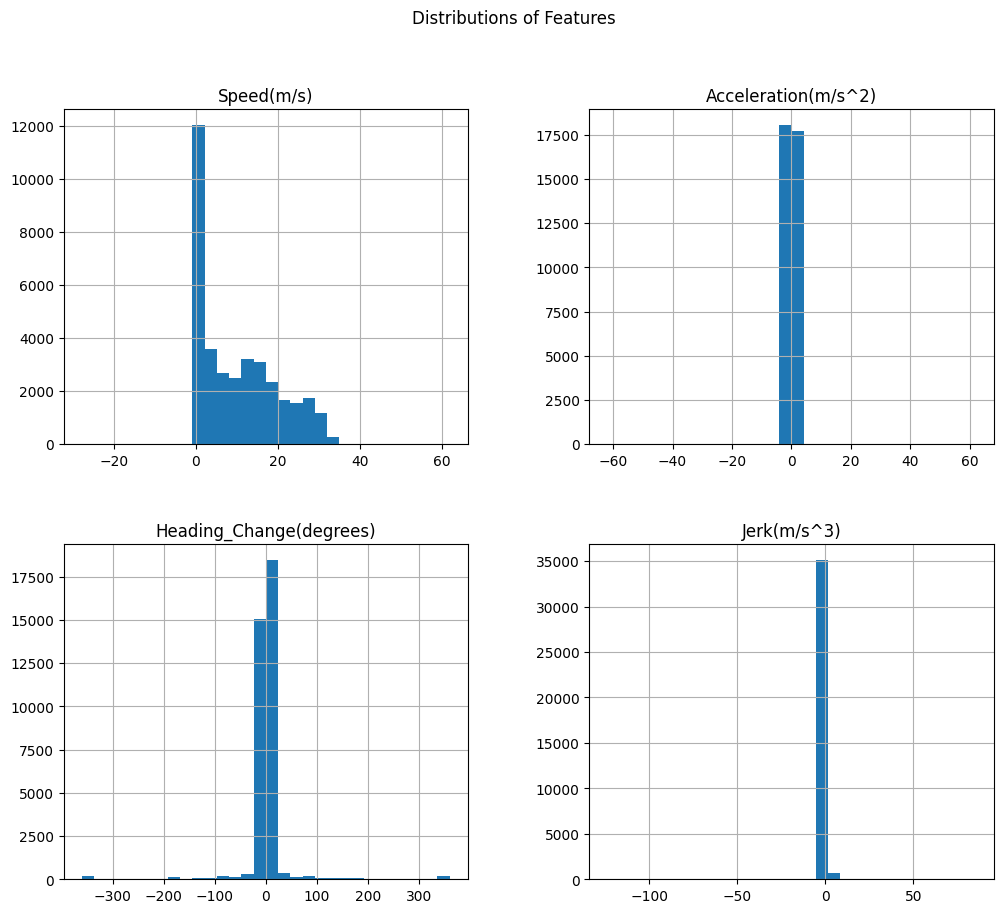

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, sqrt, atan2, degrees

# Load the raw GPS data
df = pd.read_csv('../data/driving_data.csv')

# Ensure that Time_Step, Latitude, and Longitude are numeric
df['Time_Step'] = pd.to_numeric(df['Time_Step'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop any rows where numeric conversion failed
df = df.dropna(subset=['Time_Step', 'Latitude', 'Longitude'])

# Haversine formula to calculate distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = sin(d_lat/2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(radians(d_lon/2)) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c * 1000  # Convert km to meters
    return distance

# Function to calculate heading angle between two points
def calculate_heading(lat1, lon1, lat2, lon2):
    d_lon = lon2 - lon1
    y = sin(radians(d_lon)) * cos(radians(lat2))
    x = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(d_lon))
    heading = degrees(atan2(y, x))
    return heading

# Calculate differences for time, latitude, and longitude
df['Time_Diff'] = df['Time_Step'].diff().fillna(0)
df['Lat_Diff'] = df['Latitude'].diff().fillna(0)
df['Lon_Diff'] = df['Longitude'].diff().fillna(0)

# Calculate Speed (m/s) using Haversine distance and time difference
df['Speed(m/s)'] = df.apply(lambda row: haversine(
    row['Latitude'], row['Longitude'],
    row['Latitude'] - row['Lat_Diff'], row['Longitude'] - row['Lon_Diff']
) / row['Time_Diff'] if row['Time_Diff'] != 0 else 0, axis=1)

# Calculate Heading Change (degrees)
df['Heading'] = df.apply(lambda row: calculate_heading(
    row['Latitude'] - row['Lat_Diff'], row['Longitude'] - row['Lon_Diff'],
    row['Latitude'], row['Longitude']
) if row.name != 0 else 0, axis=1)
df['Heading_Change(degrees)'] = df['Heading'].diff().fillna(0)

# Calculate Acceleration (m/s^2)
df['Acceleration(m/s^2)'] = df['Speed(m/s)'].diff() / df['Time_Diff'].replace(0, pd.NA).fillna(1)

# Calculate Jerk (m/s^3)
df['Jerk(m/s^3)'] = df['Acceleration(m/s^2)'].diff() / df['Time_Diff'].replace(0, pd.NA).fillna(1)

# Fill NaN values with 0 (after diff operations)
df = df.fillna(0)

# Filter out rows where all calculated features are zero
df = df[(df['Speed(m/s)'] != 0) | (df['Acceleration(m/s^2)'] != 0) | (df['Heading_Change(degrees)'] != 0) | (df['Jerk(m/s^3)'] != 0)]

# Calculate a continuous driving score
def calculate_driving_score(row):
    speed_score = min(max(row['Speed(m/s)'] / 11.11, 0), 1)  # Normalize to 0-1, assuming 11.11 m/s (~40 km/h) is max safe speed
    accel_score = min(max(abs(row['Acceleration(m/s^2)']) / 2, 0), 1)  # Normalize to 0-1, with 2 m/s^2 being high acceleration
    heading_score = min(max(abs(row['Heading_Change(degrees)']) / 60, 0), 1)  # Normalize to 0-1, with 60 degrees as a significant change
    jerk_score = min(max(abs(row['Jerk(m/s^3)']) / 1.5, 0), 1)  # Normalize to 0-1, with 1.5 m/s^3 being significant jerk

    # Combine the factors into a score (weighted sum)
    score = (0.4 * speed_score + 0.3 * accel_score + 0.2 * heading_score + 0.1 * jerk_score) * 100
    return score

df['Driving_Score'] = df.apply(calculate_driving_score, axis=1)

# Define thresholds for driving categories based on the driving score
def categorize_driving_score(score):
    if score < 30:
        return 'Safe'
    elif 30 <= score < 70:
        return 'Moderate'
    else:
        return 'Aggressive'

df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving_score)

# Save the processed data with scores and categories
df.to_csv('../data/processed_data.csv', index=False)

# Visualization 1: Distribution of Driving Categories
plt.figure(figsize=(8, 6))
sns.countplot(x='Driving_Category', data=df)
plt.title('Distribution of Driving Categories')
plt.xlabel('Driving Category')
plt.ylabel('Count')
plt.show()

# Visualization 2: Driving Score Distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['Driving_Score'], kde=True)
plt.title('Distribution of Driving Scores')
plt.xlabel('Driving Score')
plt.ylabel('Density')
plt.show()

# Visualization 3: Feature Distributions
features = ['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)']
df[features].hist(figsize=(12, 10), bins=30, layout=(2, 2))
plt.suptitle('Distributions of Features')
plt.show()

